This notebook contains our DANN model implementation and results. 

# Imports

The code for importing the data is largely the same as the following notebook: https://www.kaggle.com/arunlukedsouza/covid-19-chest-x-ray-classification-with-resnet-18

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"michaelmcgillicuddy","key":"c3e5cf2c2ff68b0ac65ee04b4e576efe"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip covid19-radiography-database.zip

Archive:  covid19-radiography-database.zip
replace COVID-19_Radiography_Dataset/COVID.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Imports
import os
import shutil
import random
import torch
import torchvision
import numpy as np
import torch.nn as nn

import torch.nn.init as init

from os import listdir
from os.path import splitext
from PIL import Image
from matplotlib import pyplot as plt
from distutils.dir_util import copy_tree
from torch.autograd import Variable
from sklearn.manifold import TSNE

# Define constants
max_epochs = 5
batch_size = 3
src_acc = []
tgt_acc = []

# Set random seed
torch.manual_seed(0)

# Setup of Data

This section creates the file structures necessary to process the data and loads it into the appropriate DataLoader objects for analysis with PyTorch. We also do data augmentation in this section. The code for setting up the data is adapted from https://www.kaggle.com/arunlukedsouza/covid-19-chest-x-ray-classification-with-resnet-18. Some of the changes we made were bringing in an extra dataset from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia to bring in more pneumonia and normal images to our dataset and adapting the code to use healthy and unhealthy classes instead of pneumonia & no-pneumonia.  

In [ ]:
# Define file locations
directory ='/content/COVID-19_Radiography_Dataset'

source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']
input_dir = '/content/train'
output_dir = '/content/test'

normal_dir = '/content/COVID-19_Radiography_Dataset/Normal'
pneumonia_dir_1 = '/content/COVID-19_Radiography_Dataset/Viral Pneumonia'
covid_dir = '/content/COVID-19_Radiography_Dataset/COVID'

pneumonia_dir_2 = '/content/chest_xray/train/PNEUMONIA'
    
if os.path.isdir(os.path.join(directory, source_dirs[1])):
    if os.path.exists(input_dir):
      shutil.rmtree(input_dir)
    
    # Create Train Dir
    os.makedirs(input_dir)            
    os.makedirs(input_dir + '/Normal')
    os.makedirs(input_dir + '/Viral Pneumonia')
    os.makedirs(input_dir + '/COVID')
        
    # Copy Classes to Train
    copy_tree(normal_dir, input_dir + '/Normal')
    copy_tree(pneumonia_dir_1, input_dir + '/Viral Pneumonia')
    copy_tree(pneumonia_dir_2, input_dir + '/Viral Pneumonia')

    copy_tree(covid_dir, input_dir + '/COVID')
        
    if os.path.exists(output_dir):
      shutil.rmtree(output_dir)      
          
    # Create Test Dir
    os.makedirs(output_dir)            
    os.makedirs(output_dir + '/Normal')
    os.makedirs(output_dir + '/Viral Pneumonia')
    os.makedirs(output_dir + '/COVID')

    # Create Test Dir Classes
    for c in source_dirs:
        if not os.path.isdir(os.path.join(output_dir, c)):
            os.mkdir(os.path.join(output_dir, c))

    # Choose 1000 images per type to be moved to test  
    for c in source_dirs:
        images = [x for x in os.listdir(os.path.join(input_dir, c))]# if x.lower().endswith('png')]
        selected_images = random.sample(images, 1000)
        for image in selected_images:
            source_path = os.path.join(input_dir, c, image)
            target_path = os.path.join(output_dir, c, image)
            shutil.move(source_path, target_path)

In [ ]:
#code for initializing and transforming the datasets
class ChestXRayDataset(torch.utils.data.Dataset): 
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name])]# if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Healthy', 'Unhealthy']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)


In [ ]:
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(175,175)),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

In [ ]:
test_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(175,175)),
    # We don't do data augmentation in the test/val set    
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

In [ ]:
train_dirs = {
    'Healthy': input_dir + '/Normal',
    'Unhealthy': input_dir + '/Viral Pneumonia'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 9192 Healthy examples
Found 4220 Unhealthy examples


In [ ]:
test_dirs = {
    'Healthy': output_dir + '/Normal',
    'Unhealthy': output_dir + '/Viral Pneumonia'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 1000 Healthy examples
Found 1000 Unhealthy examples


In [ ]:
DA_train_dirs = {
    'Healthy': input_dir + '/Normal',
    'Unhealthy': input_dir + '/COVID' 
}

DA_train_dataset = ChestXRayDataset(DA_train_dirs, train_transform)

Found 9192 Healthy examples
Found 2616 Unhealthy examples


In [ ]:
DA_test_dirs = {
    'Healthy': output_dir + '/Normal',
    'Unhealthy': output_dir + '/COVID' 
}

DA_test_dataset = ChestXRayDataset(DA_test_dirs, test_transform)

Found 1000 Healthy examples
Found 1000 Unhealthy examples


In [ ]:
dl_source_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dl_source_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

dl_target_train = torch.utils.data.DataLoader(DA_train_dataset, batch_size=batch_size, shuffle=True)

dl_target_test = torch.utils.data.DataLoader(DA_test_dataset, batch_size=batch_size, shuffle=True)

print('Num of source train batches', len(dl_source_train))
print('Num of source test batches', len(dl_source_test))
print('Num of target train batches', len(dl_target_train))
print('Num of target test batches', len(dl_target_test))

Num of source train batches 4471
Num of source test batches 667
Num of target train batches 3936
Num of target test batches 667


# Model Definition

This section defines the neural network architecture for the model and uses a DANN implementation with a gradient reversal layer for domain adaptation. The code is adapted from https://github.com/CuthbertCai/pytorch_DANN/, with our changes involving making it work with our dataset in general and more specifically resizing the neural network layers so they work with our dataset. The CuthbertCai repository used the MNIST and SVHN datasets (images of numbers) for their model. 

In [ ]:
#From https://github.com/CuthbertCai/pytorch_DANN/blob/540e0c1699eece8496274342e561524429de9210/models/models.py#L7
class GradReverse(torch.autograd.Function):
    """
    Extension of grad reverse layer
    """
    @staticmethod
    def forward(ctx, x, constant):
        ctx.constant = constant
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg() * ctx.constant
        return grad_output, None

    def grad_reverse(x, constant):
        return GradReverse.apply(x, constant)

In [ ]:
#Adapted from: https://github.com/CuthbertCai/pytorch_DANN/blob/master/models/models.py
import torch.nn.functional as F

class SVHN_Extractor(nn.Module):

    def __init__(self):
        super(SVHN_Extractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size= 5)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size= 5)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size= 5, padding= 2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3_drop = nn.Dropout2d()
        self.init_params()

    def init_params(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode= 'fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            if isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

    def forward(self, input):
        input = input.expand(input.data.shape[0], 3, 175, 175)
        x = F.relu(self.bn1(self.conv1(input)))
        x = F.max_pool2d(x, 3, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 3, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv3_drop(x)
        
        return x.view(-1, 128 * 40 * 40)

class SVHN_Class_classifier(nn.Module):

    def __init__(self):
        super(SVHN_Class_classifier, self).__init__()
        self.fc1 = nn.Linear(128 * 40 * 40, 3200)
        self.bn1 = nn.BatchNorm1d(3200)
        self.fc2 = nn.Linear(3200, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 10)

    def forward(self, input):
        logits = F.relu(self.bn1(self.fc1(input)))
        logits = F.dropout(logits)
        logits = F.relu(self.bn2(self.fc2(logits)))
        logits = self.fc3(logits)

        return F.log_softmax(logits, 1)

class SVHN_Domain_classifier(nn.Module):

    def __init__(self):
        super(SVHN_Domain_classifier, self).__init__()
        self.fc1 = nn.Linear(128 * 40 * 40, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 2)

    def forward(self, input, constant):
        input = GradReverse.grad_reverse(input, constant)
        logits = F.relu(self.bn1(self.fc1(input)))
        logits = F.dropout(logits)
        logits = F.relu(self.bn2(self.fc2(logits)))
        logits = F.dropout(logits)
        logits = self.fc3(logits)

        return F.log_softmax(logits, 1)

In [ ]:
# Code from https://github.com/CuthbertCai/pytorch_DANN/blob/master/util/utils.py
def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75

    return optimizer

# Training and Testing

This is the code we used to train and test our model, also adapted from https://github.com/CuthbertCai/pytorch_DANN/. 

In [ ]:
# Code adapted from https://github.com/CuthbertCai/pytorch_DANN/blob/master/train/train.py
def train(training_mode, feature_extractor, class_classifier, domain_classifier, class_criterion, domain_criterion,
          source_dataloader, target_dataloader, optimizer, epoch):
    """
    Execute target domain adaptation
    :param training_mode:
    :param feature_extractor:
    :param class_classifier:
    :param domain_classifier:
    :param class_criterion:
    :param domain_criterion:
    :param source_dataloader:
    :param target_dataloader:
    :param optimizer:
    :return:
    """

    # setup models
    feature_extractor.train()
    class_classifier.train()
    domain_classifier.train()

    # steps
    start_steps = epoch * len(source_dataloader)
    total_steps = max_epochs * len(source_dataloader)

    for batch_idx, (sdata, tdata) in enumerate(zip(source_dataloader, target_dataloader)):

        if training_mode == 'dann':
            # setup hyperparameters
            p = float(batch_idx + start_steps) / total_steps
            constant = 2. / (1. + np.exp(-10 * p)) - 1

            # prepare the data
            input1, label1 = sdata
            input2, label2 = tdata
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
            for i in [input1, label1, input2, label2]: #send data to GPU
                i = i.to(device)
            size = min((input1.shape[0], input2.shape[0]))
            input1, label1 = input1[0:size, :, :, :], label1[0:size]
            input2, label2 = input2[0:size, :, :, :], label2[0:size]

            input1, label1 = Variable(input1.cuda()), Variable(label1.cuda())
            input2, label2 = Variable(input2.cuda()), Variable(label2.cuda())

            # setup optimizer
            optimizer = optimizer_scheduler(optimizer, p)
            optimizer.zero_grad()

            # prepare domain labels
            source_labels = Variable(torch.zeros((input1.size()[0])).type(torch.LongTensor).cuda())
            target_labels = Variable(torch.ones((input2.size()[0])).type(torch.LongTensor).cuda())

            # compute the output of source domain and target domain
            src_feature = feature_extractor(input1)
            tgt_feature = feature_extractor(input2)

            # compute the class loss of src_feature
            class_preds = class_classifier(src_feature)
            class_loss = class_criterion(class_preds, label1)

            # compute the domain loss of src_feature and target_feature
            tgt_preds = domain_classifier(tgt_feature, constant)
            src_preds = domain_classifier(src_feature, constant)
            tgt_loss = domain_criterion(tgt_preds, target_labels)
            src_loss = domain_criterion(src_preds, source_labels)
            domain_loss = tgt_loss + src_loss

            loss = class_loss + 1 * domain_loss
            loss.backward()
            optimizer.step()

            # print loss
            if (batch_idx + 1) % 50 == 0:
                print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tClass Loss: {:.6f}\tDomain Loss: {:.6f}'.format(
                    batch_idx * len(input2), len(target_dataloader.dataset),
                    100. * batch_idx / len(target_dataloader), loss.item(), class_loss.item(),
                    domain_loss.item()
                ))

In [ ]:
# From https://github.com/CuthbertCai/pytorch_DANN/blob/master/train/test.py

"""
Test the model with target domain
"""

def test(feature_extractor, class_classifier, domain_classifier, source_dataloader, target_dataloader):
    """
    Test the performance of the model
    :param feature_extractor: network used to extract feature from target samples
    :param class_classifier: network used to predict labels
    :param domain_classifier: network used to predict domain
    :param source_dataloader: test dataloader of source domain
    :param target_dataloader: test dataloader of target domain
    :return: None
    """
    # setup the network
    feature_extractor.eval()
    class_classifier.eval()
    domain_classifier.eval()
    source_correct = 0.0
    target_correct = 0.0
    domain_correct = 0.0
    tgt_correct = 0.0
    src_correct = 0.0

    for batch_idx, sdata in enumerate(source_dataloader):
        # setup hyperparameters
        p = float(batch_idx) / len(source_dataloader)
        constant = 2. / (1. + np.exp(-10 * p)) - 1.

        input1, label1 = sdata

        input1, label1 = Variable(input1.cuda()), Variable(label1.cuda())
        src_labels = Variable(torch.zeros((input1.size()[0])).type(torch.LongTensor).cuda())
      
        output1 = class_classifier(feature_extractor(input1))
        pred1 = output1.data.max(1, keepdim = True)[1]
        source_correct += pred1.eq(label1.data.view_as(pred1)).cpu().sum()

        src_preds = domain_classifier(feature_extractor(input1), constant)
        src_preds = src_preds.data.max(1, keepdim= True)[1]
        src_correct += src_preds.eq(src_labels.data.view_as(src_preds)).cpu().sum()

    for batch_idx, tdata in enumerate(target_dataloader):
        # setup hyperparameters
        p = float(batch_idx) / len(source_dataloader)
        constant = 2. / (1. + np.exp(-10 * p)) - 1

        input2, label2 = tdata
        
        input2, label2 = Variable(input2.cuda()), Variable(label2.cuda())
        tgt_labels = Variable(torch.ones((input2.size()[0])).type(torch.LongTensor).cuda())

        output2 = class_classifier(feature_extractor(input2))
        pred2 = output2.data.max(1, keepdim=True)[1]
        target_correct += pred2.eq(label2.data.view_as(pred2)).cpu().sum()

        tgt_preds = domain_classifier(feature_extractor(input2), constant)
        tgt_preds = tgt_preds.data.max(1, keepdim=True)[1]
        tgt_correct += tgt_preds.eq(tgt_labels.data.view_as(tgt_preds)).cpu().sum()

    domain_correct = tgt_correct + src_correct

    src_acc.append(100. * float(source_correct) / len(source_dataloader.dataset))
    tgt_acc.append(100. * float(target_correct) / len(target_dataloader.dataset))

    print('\nSource Accuracy: {}/{} ({:.4f}%)\nTarget Accuracy: {}/{} ({:.4f}%)\n'.
        format(
        source_correct, len(source_dataloader.dataset), 100. * float(source_correct) / len(source_dataloader.dataset),
        target_correct, len(target_dataloader.dataset), 100. * float(target_correct) / len(target_dataloader.dataset)
    ))

# Execution and Results

It takes around 60-90 minutes to run the model each time. The accuracy results varied slightly each time we trained and ran the model.

In [ ]:
#intializing classes/variables necessary for training
feature_extractor = SVHN_Extractor()
class_classifier = SVHN_Class_classifier()
domain_classifier = SVHN_Domain_classifier()

if torch.cuda.is_available():
    for model in [feature_extractor, class_classifier, domain_classifier]:
        model.cuda()

curr_optimizer = torch.optim.SGD([{'params': feature_extractor.parameters()},
                        {'params': class_classifier.parameters()},
                        {'params': domain_classifier.parameters()}], lr= .01, momentum= 0.9)

#running the code to train the model
for epoch in range(max_epochs):
        print('Epoch: {}'.format(epoch+1))
        train(
            training_mode = 'dann',
            feature_extractor = feature_extractor,
            class_classifier = class_classifier,
            domain_classifier = domain_classifier,
            class_criterion = nn.NLLLoss(),
            domain_criterion = nn.NLLLoss(),
            source_dataloader = dl_source_train,
            target_dataloader = dl_target_train,
            optimizer = curr_optimizer,
            epoch = epoch)
        test(feature_extractor, class_classifier, domain_classifier, dl_source_test, dl_target_test)

Epoch: 1
[147/11808 (1%)]	Loss: 15.218534	Class Loss: 0.002978	Domain Loss: 15.215555
[297/11808 (3%)]	Loss: 22.098192	Class Loss: 0.000000	Domain Loss: 22.098192
[447/11808 (4%)]	Loss: 28.462948	Class Loss: 7.508236	Domain Loss: 20.954712
[597/11808 (5%)]	Loss: 21.325884	Class Loss: 0.010696	Domain Loss: 21.315187
[747/11808 (6%)]	Loss: 9.139538	Class Loss: 0.000047	Domain Loss: 9.139491
[897/11808 (8%)]	Loss: 8.356174	Class Loss: 0.000000	Domain Loss: 8.356174
[1047/11808 (9%)]	Loss: 2.327026	Class Loss: 0.613053	Domain Loss: 1.713973
[1197/11808 (10%)]	Loss: 9.957016	Class Loss: 4.197675	Domain Loss: 5.759341
[1347/11808 (11%)]	Loss: 1.828656	Class Loss: 0.000000	Domain Loss: 1.828656
[1497/11808 (13%)]	Loss: 4.783556	Class Loss: 1.619757	Domain Loss: 3.163800
[1647/11808 (14%)]	Loss: 3.038420	Class Loss: 0.259482	Domain Loss: 2.778938
[1797/11808 (15%)]	Loss: 3.697601	Class Loss: 0.821261	Domain Loss: 2.876340
[1947/11808 (16%)]	Loss: 20.829535	Class Loss: 17.270559	Domain Loss: 3.

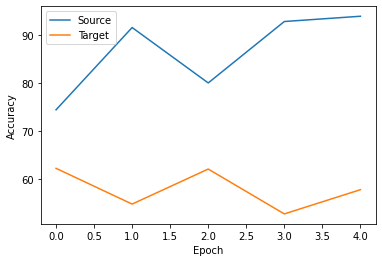

In [ ]:
# Accuracy
fig,ax=plt.subplots()
ax.plot(range(len(src_acc)), src_acc, label="Source")
ax.plot(range(len(tgt_acc)), tgt_acc, label="Target")
plt.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
plt.show()

In [ ]:
max(src_acc)

93.95

In [ ]:
max(tgt_acc)

62.25